In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle competitions/"

In [ ]:
#!mkdir '/content/drive/MyDrive/kaggle competitions/facial-emotions-recognition'

In [ ]:
%cd '.'
!kaggle datasets download -d chiragsoni/ferdata

/content
 81% 49.0M/60.3M [00:01<00:00, 31.8MB/s]
100% 60.3M/60.3M [00:01<00:00, 33.1MB/s]


In [ ]:
!unzip '/content/ferdata.zip'

In [ ]:
data_dir = '/content'
os.listdir(data_dir)

['.config', 'train', 'ferdata.zip', 'drive', 'test', 'sample_data']

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.listdir(os.path.join(data_dir, 'train'))

['surprise', 'angry', 'fear', 'disgust', 'neutral', 'happy', 'sad']

In [ ]:
train_folder = os.path.join(data_dir, 'train')
test_folder = os.path.join(data_dir, 'test')
for cls in os.listdir(train_folder):
  print(f'There are [{len(os.listdir(os.path.join(train_folder, cls)))}] images of the [{cls}] class in train dataset')
  print(f'There are [{len(os.listdir(os.path.join(test_folder, cls)))}] images of the [{cls}] class in test dataset')
del cls

There are [3171] images of the [surprise] class in train dataset
There are [831] images of the [surprise] class in test dataset
There are [3995] images of the [angry] class in train dataset
There are [958] images of the [angry] class in test dataset
There are [4097] images of the [fear] class in train dataset
There are [1024] images of the [fear] class in test dataset
There are [436] images of the [disgust] class in train dataset
There are [111] images of the [disgust] class in test dataset
There are [4965] images of the [neutral] class in train dataset
There are [1233] images of the [neutral] class in test dataset
There are [7215] images of the [happy] class in train dataset
There are [1774] images of the [happy] class in test dataset
There are [4830] images of the [sad] class in train dataset
There are [1247] images of the [sad] class in test dataset


In [ ]:
stats_train = ((0.5077, 0.5077, 0.5077), (0.2187, 0.2187, 0.2187))
stats_test = ((0.5060, 0.5060, 0.5060), 0.2192, 0.2192, 0.2192)

In [ ]:
train_tfms = tt.Compose([tt.Grayscale(),
                         tt.RandomRotation(degrees=(0, 30)),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(0.5, 0.5)])
test_tfms = tt.Compose([tt.Grayscale(), tt.ToTensor()])

In [ ]:
train_data = ImageFolder(train_folder, transform=train_tfms)
test_ds = ImageFolder(test_folder, transform=test_tfms)
del train_tfms, test_tfms

In [ ]:
len(train_data), len(test_ds)

(28709, 7178)

torch.Size([1, 48, 48])
5 sad


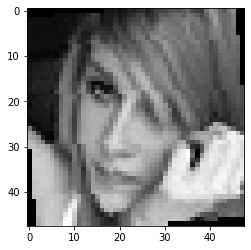

In [ ]:
img, label = train_data[22045]
print(img.shape)
print(label, train_data.classes[label])
plt.imshow(img.squeeze(), cmap='gray');
del img, label

In [ ]:
val_size = int(len(train_data) * 0.15)
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(24403, 4306)

In [ ]:
# nimages = 0
# mean = 0.0
# var = 0.0
# for i_batch, batch_target in enumerate(test_dl):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0)
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print(mean)
# print(std)

In [ ]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def denormalize(images, stats):
  means, stds = stats
  return images * stds + means
def show_batch(dl):
  for images, _ in dl:
    print(images.shape)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, (0.5, 0.5))
    ax.imshow(make_grid(denorm_images, nrow=10).permute(1, 2, 0).clamp(0, 1))
    break

torch.Size([100, 1, 48, 48])


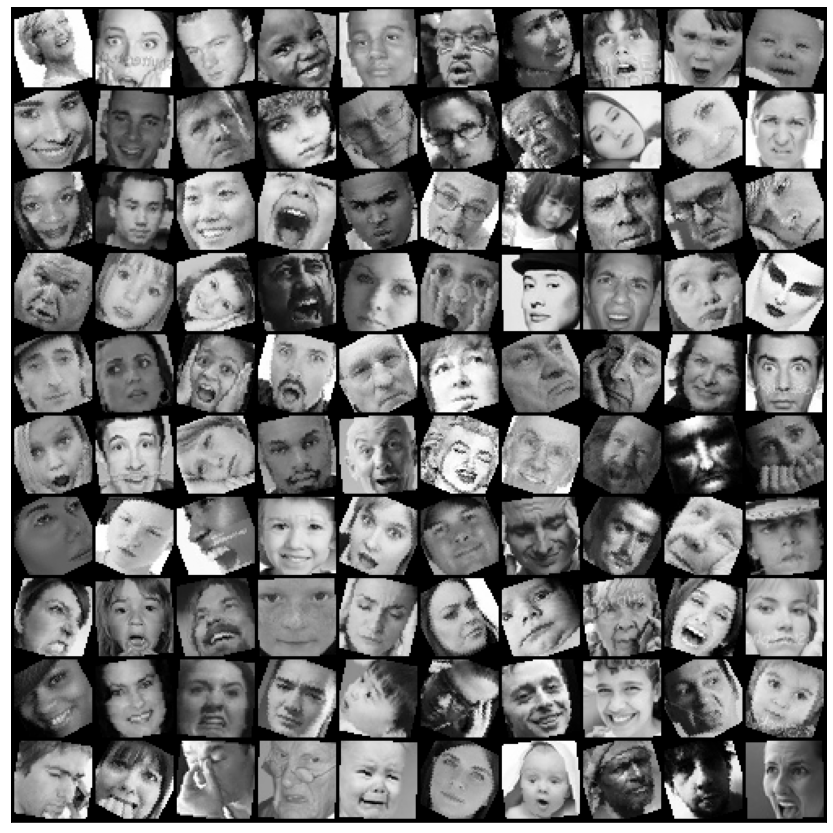

In [ ]:
show_batch(train_dl)

In [ ]:
def accuracy(out, targets):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
class ClassificationBase(nn.Module):
  def training_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    return loss
  def validaiton_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    acc = accuracy(out, targets)
    return {'loss': loss, 'acc': acc}
  def validation_epoch_end(self, res):
    losses = [x['loss'] for x in res]
    loss = torch.stack(losses).mean()
    accs = [x['acc'] for x in res]
    acc = torch.stack(accs).mean()
    return {'loss': loss.item(), 'acc': acc.item()}
  def epoch_end(self, epoch, res):
    print(f'Epoch: [{epoch}], Last lr: [{res["lrs"][-1]}], Train loss: [{round(res["train_loss"], 4)}], Val loss: [{round(res["loss"], 4)}], Val acc: [{round(res["acc"], 4)}]')

In [ ]:
def get_default_device():
  return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def conv_block(in_channels: int, out_channels: int,
               pool: bool=False, dropout: bool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()]
  if pool: layers.append(nn.MaxPool2d(2))
  if dropout: layers.append(nn.Dropout(0.2))
  return nn.Sequential(*layers)

In [ ]:
len(train_data.classes)

7

In [ ]:
import torchvision.models as models
resnet50 = models.resnet50()
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class Model1(ClassificationBase):
  '''
  Kinda Resnet9
  ~ 24 % accuracy
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.conv1 = conv_block(in_channels, 16) # 16 x 48 x 48
    self.conv2 = conv_block(16, 32, pool=True) # 32 x 24 x 24
    self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))

    self.conv3 = conv_block(32, 64, pool=True) # 64 x 12 x 12
    self.conv4 = conv_block(64, 128, pool=True) # 128 x 6 x 6
    self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv5 = conv_block(128, 256, pool=True) # 256 x 3 x 3
    self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256)) # 256 x 3 x 3

    self.classifier = nn.Sequential(nn.MaxPool2d(3), # 256 x 1 x 1
                                    nn.Flatten(), # 256
                                    nn.Linear(256, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 64),
                                    nn.ReLU(),
                                    nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(32, n_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.res3(out) + out
    out = self.classifier(out)
    return out

In [ ]:
class ResNet9(ClassificationBase):
  '''
  Classical ResNet9
  ~ 48 % accuracy after training
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64, pool=True)    # 64 x 24 x 24
    self.conv2 = conv_block(64, 128, pool=True) # 128 x 12 x 12
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 12 x 12

    self.conv3 = conv_block(128, 256, pool=True) # 256 x 6 x 6
    self.conv4 = conv_block(256, 512, pool=True) # 512 x 3 x 3
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 3 x 3

    self.classifier = nn.Sequential(nn.MaxPool2d(3), # 512 x 1 x 1
                                    nn.Flatten(), # 512
                                    nn.Dropout(0.2),
                                    nn.Linear(512, n_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [ ]:
class Model2(ClassificationBase):
  '''
  Kinda ResNet with 13 layers
  ~ 55 % accuracy
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.conv1 = conv_block(in_channels, 8) # 8 x 48 x 48
    self.conv2 = conv_block(8, 16, pool=True, dropout=True) # 16 x 24 x 24
    self.res1 = nn.Sequential(conv_block(16, 16), conv_block(16, 16))

    self.conv3 = conv_block(16, 32, pool=True) # 32 x 12 x 12
    self.conv4 = conv_block(32, 64, pool=True, dropout=True) # 64 x 6 x 6
    self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

    self.conv5 = conv_block(64, 128, pool=True) # 128 x 3 x 3
    self.conv6 = conv_block(128, 256, dropout=True) # 256 x 3 x 3
    self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

    self.classifier = nn.Sequential(nn.Flatten(), # 256*3*3
                                    nn.Linear(256*3*3, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256, n_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.classifier(out)
    return out

In [ ]:
class CNN(ClassificationBase):
  '''
  CNN - No residuals addition, 11 layers and classifier
  ~ __ % accuracy
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.conv1 = conv_block(in_channels, 4) # 4 x 48 x 48
    self.conv2 = conv_block(4, 8, pool=True, dropout=True) # 8 x 24 x 24
    self.conv3 = conv_block(8, 16) # 16 x 24 x 24
    self.conv4 = conv_block(16, 32, pool=True, dropout=True) # 32 x 12 x 12
    self.conv5 = conv_block(32, 64) # 64 x 12 x 12
    self.conv6 = conv_block(64, 128, pool=True, dropout=True) # 128 x 6 x 6
    self.conv7 = conv_block(128, 256) # 256 x 6 x 6
    self.conv8 = conv_block(256, 512, pool=True, dropout=True) # 512 x 3 x 3
    self.conv9 = conv_block(512, 1024) # 1024 x 3 x 3
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # 1024 x 2 x 2
    self.conv10 = conv_block(1024, 2048) # 2048 x 2 x 2
    self.conv11 = conv_block(2048, 4096, pool=True, dropout=True) # 4096 x 1 x 1
    self.classifier = nn.Sequential(nn.Flatten(), # 4096 * 1 * 1
                                    nn.Linear(4096, 2048),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(2048, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(512, n_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.conv7(out)
    out = self.conv8(out)
    out = self.conv9(out)
    out = self.pool(out)
    out = self.conv10(out)
    out = self.conv11(out)
    out = self.classifier(out)
    return out

In [ ]:
class Model3(ClassificationBase):
  '''
  Somerthing like ResNet with 21 layers
  ~ 25 % accuracy
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.conv1 = conv_block(in_channels, 8) # 8 x 48 x 48
    self.conv2 = conv_block(8, 16, pool=True, dropout=True) # 16 x 24 x 24
    self.res1 = nn.Sequential(conv_block(16, 16), conv_block(16, 16))

    self.conv3 = conv_block(16, 32) # 32 x 24 x 24
    self.conv4 = conv_block(32, 64, pool=True, dropout=True) # 64 x 12 x 12
    self.res2 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))

    self.conv5 = conv_block(64, 128) # 128 x 12 x 12
    self.conv6 = conv_block(128, 256, pool=True, dropout=True) # 256 x 6 x 6
    self.res3 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

    self.conv7 = conv_block(256, 512) # 512 x 6 x 6
    self.conv8 = conv_block(512, 1024, pool=True, dropout=True) # 1024 x 3 x 3
    self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

    self.conv9 = conv_block(1024, 2048) # 2048 x 3 x 3
    self.conv10 = conv_block(2048, 4096, dropout=True) # 4096 x 3 x 3
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # 4096 x 2 x 2
    self.res5 = nn.Sequential(conv_block(4096, 4096), conv_block(4096, 4096))

    self.classifier = nn.Sequential(nn.MaxPool2d(2), # 4086 x 1 x 1
                                    nn.Flatten(), # 4096 * 1 * 1
                                    nn.Linear(4096, 2048),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(2048, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(512, n_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out)
    out = self.conv7(out)
    out = self.conv8(out)
    out = self.res4(out)
    out = self.conv9(out)
    out = self.conv10(out)
    out = self.pool(out)
    out = self.res5(out) + out
    out = self.classifier(out)
    return out

In [ ]:
class ResNet50(ClassificationBase):
  '''
  ResNet50
  ~ 5
  '''
  def __init__(self, in_channels: int=1, n_classes: int=7):
    super().__init__()
    self.network = models.resnet50(pretrained=True)
    self.network.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.network.fc = nn.Linear(2048, 7, bias=True)

  def forward(self, xb):
    return self.network(xb)

  def freeze(self):
    for param in self.network.parameters():
      param.requires_grad = False
    for param in self.network.fc.parameters():
      param.requires_grad = True

  def unfreeze(self):
    for param in self.network.parameters():
      param.requires_grad = True

In [ ]:
@torch.no_grad()
def evaluate(model, dl):
  model.eval()
  res = [model.validaiton_step(batch) for batch in dl]
  return model.validation_epoch_end(res)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, model, train_dl, val_dl, max_lr,
                  opt_f=torch.optim.SGD,
                  weight_decay=0,
                  grad_clip=None):
  torch.cuda.empty_cache()
  history = []
  optimizer = opt_f(model.parameters(), max_lr)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                              steps_per_epoch=len(train_dl))
  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for b in tqdm(train_dl):
      loss = model.training_step(b)
      train_losses.append(loss)
      loss.backward()
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    res = evaluate(model, val_dl)
    res['lrs'] = lrs
    res['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(res)
    model.epoch_end(epoch, res)
  return history

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model = to_device(ResNet50(), device)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet50(
  (network): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'acc': 0.09292454272508621, 'loss': 2.1179776191711426}]

In [ ]:
model.unfreeze()

In [ ]:
epochs = 30
max_lr = 1e-7
weight_decay = 1e-6
grad_clip = 1e-4
opt_f = torch.optim.Adam

In [ ]:
# Epoch: [19], Last lr: [3.6000000000000003e-06], Train loss: [1.8094], Val loss: [1.8072], Val acc: [0.2502]
# 54 mins
%%time
history += fit_one_cycle(epochs, model, train_dl, val_dl, max_lr,
                          opt_f=opt_f,
                          weight_decay=weight_decay,
                          grad_clip=grad_clip)

  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [0], Last lr: [6.873989677794506e-09], Train loss: [1.06], Val loss: [1.1727], Val acc: [0.5604]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [1], Last lr: [1.5195683314250733e-08], Train loss: [1.0671], Val loss: [1.1819], Val acc: [0.549]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [2], Last lr: [2.7960508859577264e-08], Train loss: [1.0655], Val loss: [1.1879], Val acc: [0.5565]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [3], Last lr: [4.3627456758404095e-08], Train loss: [1.0645], Val loss: [1.183], Val acc: [0.5533]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [4], Last lr: [6.03051641926616e-08], Train loss: [1.0646], Val loss: [1.1983], Val acc: [0.5593]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [5], Last lr: [7.598024630044183e-08], Train loss: [1.069], Val loss: [1.1891], Val acc: [0.5527]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [6], Last lr: [8.876035827659841e-08], Train loss: [1.0634], Val loss: [1.1934], Val acc: [0.5483]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [7], Last lr: [9.710264514015072e-08], Train loss: [1.0689], Val loss: [1.1887], Val acc: [0.5529]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [8], Last lr: [1e-07], Train loss: [1.0741], Val loss: [1.1975], Val acc: [0.5569]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [9], Last lr: [9.944154354509117e-08], Train loss: [1.0714], Val loss: [1.2018], Val acc: [0.5436]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [10], Last lr: [9.777864917474588e-08], Train loss: [1.0631], Val loss: [1.1818], Val acc: [0.5541]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [11], Last lr: [9.504846320134737e-08], Train loss: [1.0636], Val loss: [1.1859], Val acc: [0.5584]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [12], Last lr: [9.131197346804488e-08], Train loss: [1.0683], Val loss: [1.1901], Val acc: [0.553]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [13], Last lr: [8.665264698111694e-08], Train loss: [1.0635], Val loss: [1.1949], Val acc: [0.552]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [14], Last lr: [8.11745653949763e-08], Train loss: [1.0647], Val loss: [1.1946], Val acc: [0.5591]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [15], Last lr: [7.500009999999999e-08], Train loss: [1.0649], Val loss: [1.1817], Val acc: [0.5552]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [16], Last lr: [6.826717815011488e-08], Train loss: [1.0696], Val loss: [1.1837], Val acc: [0.5581]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [17], Last lr: [6.112620219362892e-08], Train loss: [1.062], Val loss: [1.1918], Val acc: [0.5511]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [18], Last lr: [5.3736689733302505e-08], Train loss: [1.0658], Val loss: [1.1932], Val acc: [0.5481]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [19], Last lr: [4.6263710266697505e-08], Train loss: [1.0701], Val loss: [1.19], Val acc: [0.5519]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [20], Last lr: [3.887419780637108e-08], Train loss: [1.0611], Val loss: [1.1752], Val acc: [0.5558]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [21], Last lr: [3.1733221849885124e-08], Train loss: [1.0628], Val loss: [1.195], Val acc: [0.558]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [22], Last lr: [2.500030000000001e-08], Train loss: [1.0677], Val loss: [1.2055], Val acc: [0.5487]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [23], Last lr: [1.8825834605023696e-08], Train loss: [1.0656], Val loss: [1.1881], Val acc: [0.5598]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [24], Last lr: [1.334775301888306e-08], Train loss: [1.0671], Val loss: [1.1715], Val acc: [0.5647]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [25], Last lr: [8.688426531955129e-09], Train loss: [1.0621], Val loss: [1.2025], Val acc: [0.5494]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [26], Last lr: [4.951936798652629e-09], Train loss: [1.0663], Val loss: [1.1916], Val acc: [0.5548]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [27], Last lr: [2.221750825254118e-09], Train loss: [1.0653], Val loss: [1.1812], Val acc: [0.5544]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [28], Last lr: [5.588564549088188e-10], Train loss: [1.0637], Val loss: [1.189], Val acc: [0.5526]


  0%|          | 0/245 [00:00<?, ?it/s]

Epoch: [29], Last lr: [3.9999999999999996e-13], Train loss: [1.0625], Val loss: [1.1886], Val acc: [0.5602]
CPU times: user 10min 42s, sys: 58.5 s, total: 11min 41s
Wall time: 13min 36s


In [ ]:
evaluate(model, test_dl)

{'acc': 0.5117010474205017, 'loss': 1.2639487981796265}

In [ ]:
def plot_accs(history):
  accs = [x['acc'] for x in history]
  plt.figure(figsize=(25,9))
  plt.plot(accs, '-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy score')
  plt.title('MDOEL ACCURACY x EPOCH N.');

def plot_losses(history):
  val_losses = [x['loss'] for x in history]
  train_losses = [x.get('train_loss') for x in history]
  plt.figure(figsize=(25,9))
  plt.plot(train_losses, label='Train')
  plt.plot(val_losses, label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy score')
  plt.title('LOSS x EPOCH N.')
  plt.legend();

def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.figure(figsize=(25,9))
  plt.plot(lrs)
  plt.xlabel('Batch')
  plt.ylabel('Learning rate')
  plt.title('LEARNING RATES x BATCH N.');

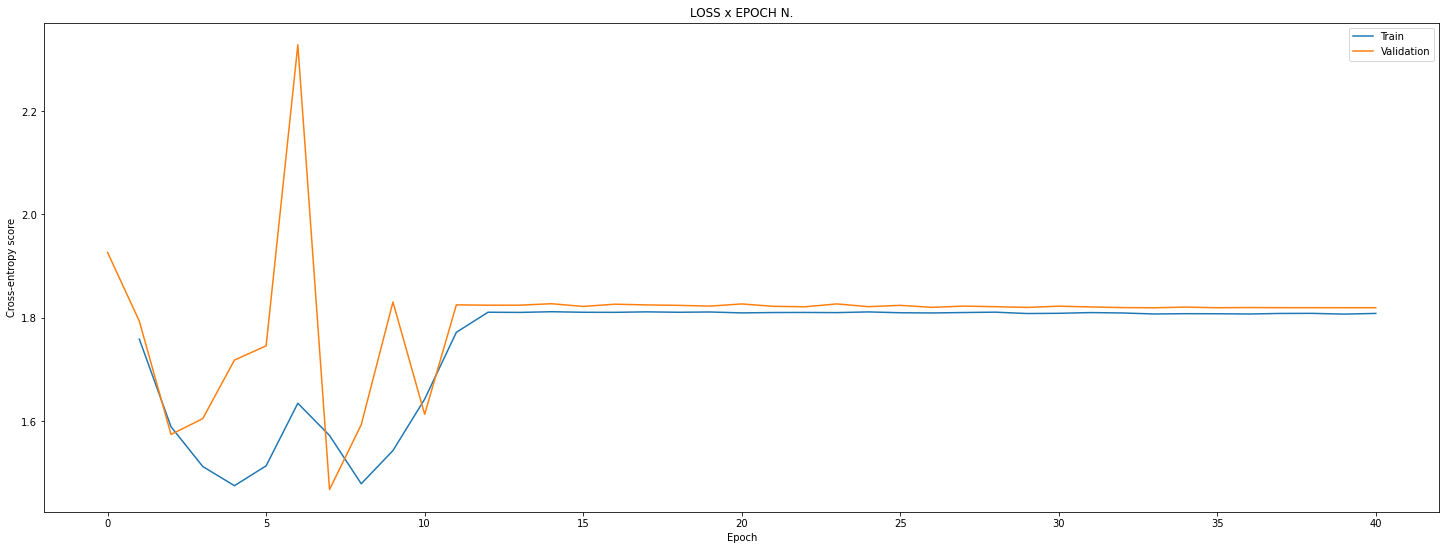

In [ ]:
plot_losses(history1)